In [1]:
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
from abc import ABCMeta, abstractmethod
from activation_func import *
from loss_func import *
import cv2
import pandas as pd

from tqdm.notebook import tqdm

In [2]:
def MakeOneHot(Y, D_out):
    N = Y.shape[0]
    Z = np.zeros((N, D_out))
    Z[np.arange(N), Y] = 1
    return Z

def draw_losses(losses):
    t = np.arange(len(losses))
    plt.plot(t, losses)
    plt.show()

def get_batch(X, Y, batch_size):
    N = len(X)
    i = random.randint(1, N-batch_size)
    return X[i:i+batch_size], Y[i:i+batch_size]

class FC():
    """
    Fully connected layer
    """
    def __init__(self, D_in, D_out):
        #print("Build FC")
        self.cache = None
        #self.W = {'val': np.random.randn(D_in, D_out), 'grad': 0}
        self.W = {'val': np.random.normal(0.0, np.sqrt(2/D_in), (D_in,D_out)), 'grad': 0}
        self.b = {'val': np.random.randn(D_out), 'grad': 0}

    def _forward(self, X):
        #print("FC: _forward")
        out = np.dot(X, self.W['val']) + self.b['val']
        self.cache = X
        return out

    def _backward(self, dout):
        #print("FC: _backward")
        X = self.cache
        dX = np.dot(dout, self.W['val'].T).reshape(X.shape)
        self.W['grad'] = np.dot(X.reshape(X.shape[0], np.prod(X.shape[1:])).T, dout)
        self.b['grad'] = np.sum(dout, axis=0)
        #self._update_params()
        return dX

    def _update_params(self, lr=0.001):
        # Update the parameters
        self.W['val'] -= lr*self.W['grad']
        self.b['val'] -= lr*self.b['grad']



class Dropout():
    """
    Dropout layer
    """
    def __init__(self, p=1):
        self.cache = None
        self.p = p

    def _forward(self, X):
        M = (np.random.rand(*X.shape) < self.p) / self.p
        self.cache = X, M
        return X*M

    def _backward(self, dout):
        X, M = self.cache
        dX = dout*M/self.p
        return dX

class Conv:
    # 初始化权重（卷积核4维）、偏置、步幅、填充
    def __init__(self, Cin, Cout, X_H, X_W, F, stride, pad):

        self.stride = stride
        self.pad = pad
        # 中间数据（backward时使用）
        self.x = None   
        self.col = None
        self.col_W = None
        self.W = {'val': np.random.normal(0.0,np.sqrt(2/Cin),(Cout,Cin,F,F)), 'grad': 0} # Xavier Initialization
        self.b = {'val': np.random.randn(Cout), 'grad': 0}
        self.X_H = X_H
        self.X_W = X_W
        self.Cin = Cin

    def _forward(self, x):
        x = x.reshape(x.shape[0], self.Cin, self.X_H, self.X_W)
        # 卷积核大小
        FN, C, FH, FW = self.W['val'].shape
        # 数据数据大小
        N, C, H, W = x.shape
        # 计算输出数据大小
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)
        # 利用im2col转换为行
        col = im2col(x, FH, FW, self.stride, self.pad)
        # 卷积核转换为列，展开为2维数组
        col_W = self.W['val'].reshape(FN, -1).T
        # 计算正向传播
        out = np.dot(col, col_W) + self.b['val']
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def _backward(self, dout):
        # 卷积核大小
        FN, C, FH, FW = self.W['val'].shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        db = np.sum(dout, axis=0)
        dW = np.dot(self.col.T, dout)
        dW = dW.transpose(1, 0).reshape(FN, C, FH, FW)

        self.W['grad'] = dW
        self.b['grad'] = db

        dcol = np.dot(dout, self.col_W.T)
        # 逆转换
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx

class MaxPool:
    def __init__(self, pool_h, pool_w, stride=2, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def _forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        # 展开
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)
        # 最大值
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        # 转换
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def _backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx


class Net(metaclass=ABCMeta):
    # Neural network super class

    @abstractmethod
    def __init__(self):
        pass

    @abstractmethod
    def forward(self, X):
        pass

    @abstractmethod
    def backward(self, dout):
        pass

    @abstractmethod
    def get_params(self):
        pass

    @abstractmethod
    def set_params(self, params):
        pass


class TwoLayerNet(Net):

    #Simple 2 layer NN

    def __init__(self, N, D_in, H, D_out, weights=''):
        self.FC1 = FC(D_in, H)
        self.ReLU1 = ReLU()
        self.FC2 = FC(H, D_out)

        if weights == '':
            pass
        else:
            with open(weights,'rb') as f:
                params = pickle.load(f)
                self.set_params(params)

    def forward(self, X):
        h1 = self.FC1._forward(X)
        a1 = self.ReLU1._forward(h1)
        h2 = self.FC2._forward(a1)
        return h2

    def backward(self, dout):
        dout = self.FC2._backward(dout)
        dout = self.ReLU1._backward(dout)
        dout = self.FC1._backward(dout)

    def get_params(self):
        return [self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b]

    def set_params(self, params):
        [self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b] = params


class ThreeLayerNet(Net):

    #Simple 3 layer NN

    def __init__(self, N, D_in, H1, H2, D_out, weights=''):
        self.FC1 = FC(D_in, H1)
        self.ReLU1 = ReLU()
        self.FC2 = FC(H1, H2)
        self.ReLU2 = ReLU()
        self.FC3 = FC(H2, D_out)

        if weights == '':
            pass
        else:
            with open(weights,'rb') as f:
                params = pickle.load(f)
                self.set_params(params)

    def forward(self, X):
        h1 = self.FC1._forward(X)
        a1 = self.ReLU1._forward(h1)
        h2 = self.FC2._forward(a1)
        a2 = self.ReLU2._forward(h2)
        h3 = self.FC3._forward(a2)
        return h3

    def backward(self, dout):
        dout = self.FC3._backward(dout)
        dout = self.ReLU2._backward(dout)
        dout = self.FC2._backward(dout)
        dout = self.ReLU1._backward(dout)
        dout = self.FC1._backward(dout)

    def get_params(self):
        return [self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b, self.FC3.W, self.FC3.b]

    def set_params(self, params):
        [self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b, self.FC3.W, self.FC3.b] = params


class LeNet5(Net):
    # LeNet5

    def __init__(self):
        self.conv1 = Conv(3, 6, 64, 64, 5, 1, 0)
        self.Sigmoid1 = Sigmoid()
        self.pool1 = MaxPool(2,2)
        self.conv2 = Conv(6, 16, 30, 30, 5, 1, 0)
        self.Sigmoid2 = Sigmoid()
        self.pool2 = MaxPool(2,2)
        self.FC1 = FC(16*13*13, 120)
        self.Sigmoid3 = Sigmoid()
        self.FC2 = FC(120, 84)
        self.Sigmoid4 = Sigmoid()
        self.FC3 = FC(84, 50)
        self.Softmax = Softmax()
        self.p2_shape = None

    def forward(self, X):
        h1 = self.conv1._forward(X)
        a1 = self.Sigmoid1._forward(h1)
        p1 = self.pool1._forward(a1)
        h2 = self.conv2._forward(p1)
        a2 = self.Sigmoid2._forward(h2)
        p2 = self.pool2._forward(a2)
        self.p2_shape = p2.shape
        fl = p2.reshape(X.shape[0],-1) # Flatten
        h3 = self.FC1._forward(fl)
        a3 = self.Sigmoid3._forward(h3)
        h4 = self.FC2._forward(a3)
        a5 = self.Sigmoid4._forward(h4)
        h5 = self.FC3._forward(a5)
        a5 = self.Softmax._forward(h5)
        return a5

    def backward(self, dout):
        #dout = self.Softmax._backward(dout)
        dout = self.FC3._backward(dout)
        dout = self.Sigmoid4._backward(dout)
        dout = self.FC2._backward(dout)
        dout = self.Sigmoid3._backward(dout)
        dout = self.FC1._backward(dout)
        dout = dout.reshape(self.p2_shape) # reshape
        dout = self.pool2._backward(dout)
        dout = self.Sigmoid2._backward(dout)
        dout = self.conv2._backward(dout)
        dout = self.pool1._backward(dout)
        dout = self.Sigmoid1._backward(dout)
        dout = self.conv1._backward(dout)

    def get_params(self):
        return [self.conv1.W, self.conv1.b, self.conv2.W, self.conv2.b, self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b, self.FC3.W, self.FC3.b]

    def set_params(self, params):
        [self.conv1.W, self.conv1.b, self.conv2.W, self.conv2.b, self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b, self.FC3.W, self.FC3.b] = params

class SGD():
    def __init__(self, params, lr=0.001, reg=0):
        self.parameters = params
        self.lr = lr
        self.reg = reg

    def step(self):
        for param in self.parameters:
            param['val'] -= (self.lr*param['grad'] + self.reg*param['val'])

class SGDMomentum():
    def __init__(self, params, lr=0.001, momentum=0.99, reg=0):
        self.l = len(params)
        self.parameters = params
        self.velocities = []
        for param in self.parameters:
            self.velocities.append(np.zeros(param['val'].shape))
        self.lr = lr
        self.rho = momentum
        self.reg = reg

    def step(self):
        for i in range(self.l):
            self.velocities[i] = self.rho*self.velocities[i] + (1-self.rho)*self.parameters[i]['grad']
            self.parameters[i]['val'] -= (self.lr*self.velocities[i] + self.reg*self.parameters[i]['val'])


In [3]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):

    # 输入数据的形状
    # N：批数目，C：通道数，H：输入数据高，W：输入数据长
    N, C, H, W = input_data.shape  
    out_h = (H + 2*pad - filter_h)//stride + 1  # 输出数据的高
    out_w = (W + 2*pad - filter_w)//stride + 1  # 输出数据的长
    # 填充 H,W
    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    # (N, C, filter_h, filter_w, out_h, out_w)的0矩阵
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))
    
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
    # 按(0, 4, 5, 1, 2, 3)顺序，交换col的列，然后改变形状
    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

## Data Preprocessing

In [4]:
trainDF = pd.read_csv("train.txt", sep=" ", header = None)
trainDF.columns = ["file_path", "img_label"]

valDF = pd.read_csv("val.txt", sep=" ", header = None)
valDF.columns = ["file_path", "img_label"]

testDF = pd.read_csv("test.txt", sep=" ", header = None)
testDF.columns = ["file_path", "img_label"]

In [102]:
DFname = ["trainDF", "valDF", "testDF"]

for i_df in DFname:
    for idx in tqdm(range(len(eval(i_df)))):
        image = cv2.imread(eval(i_df).iloc[idx, 0])
        img1 = cv2.resize(image, (64, 64)) #size -> (64,64,3)
        if idx == 0:
            ### example code: train_img=np.expand_dims(img1, axis=0)
            eval('exec(i_df+"array"+"=np.expand_dims(img1, axis=0)")') #新增樣本數維度 #size -> (1,64,64,3)
        else:
            ### example code: train_img=np.appensd(train_img, np.expand_dims(img1, axis=0),axis=0)
            ### output: trainDFarray,valDFarray, testDFarray
            eval('''exec(i_df+"array"+'=np.append(eval(i_df+"array"), np.expand_dims(img1, axis=0), axis=0)')''')

  0%|          | 0/63325 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

## save and read resize image array

In [58]:
with open('train.npy', 'wb') as f:
    np.save(f, trainDFarray)
with open('test.npy', 'wb') as f:
    np.save(f, testDFarray)
with open('val.npy', 'wb') as f:
    np.save(f, valDFarray)

(64, 1, 28, 28)

In [5]:
with open('train.npy', 'rb') as f:
    trainDFarray = np.load(f)  
with open('test.npy', 'rb') as f:
    testDFarray = np.load(f)
with open('val.npy', 'rb') as f:
    valDFarray = np.load(f)

## train model

iter: 0, loss: 3.9171505448448096
iter: 1, loss: 3.9187937093935123
iter: 2, loss: 3.922653401663963
iter: 3, loss: 3.9037570351964703
iter: 4, loss: 3.924451492587968
iter: 5, loss: 3.861993849090142
iter: 6, loss: 3.92458398093134
iter: 7, loss: 3.923881417056322
iter: 8, loss: 3.926080801903169
iter: 9, loss: 3.836264168938314
iter: 10, loss: 3.9262503857383844
iter: 11, loss: 3.8820507574759513
iter: 12, loss: 3.9259146702254366
iter: 13, loss: 3.92112002517252
iter: 14, loss: 3.920772696099767
iter: 15, loss: 3.9256317082944676
iter: 16, loss: 3.924012327916899
iter: 17, loss: 3.9153754612055196
iter: 18, loss: 3.8952756212897053
iter: 19, loss: 3.9312238022593746
iter: 20, loss: 3.9286609192461626
iter: 21, loss: 3.8447545415455755
iter: 22, loss: 3.92844624327688
iter: 23, loss: 3.9313019500819237
iter: 24, loss: 3.8192454617397473
iter: 25, loss: 3.874254105878599
iter: 26, loss: 3.9239459972424675
iter: 27, loss: 3.93053945106832
iter: 28, loss: 3.9315352627853817
iter: 29, lo

iter: 234, loss: 3.930562088336728
iter: 235, loss: 3.9202828059671884
iter: 236, loss: 3.9234580532625483
iter: 237, loss: 3.923547849905703
iter: 238, loss: 3.9283215068933277
iter: 239, loss: 3.9303328337705974
iter: 240, loss: 3.9217975129086557
iter: 241, loss: 3.82210844434316
iter: 242, loss: 3.9281267237074293
iter: 243, loss: 3.9249427866722257
iter: 244, loss: 3.9295908486839157
iter: 245, loss: 3.9286990742029335
iter: 246, loss: 3.9295374758992465
iter: 247, loss: 3.915831139298008
iter: 248, loss: 3.906399371911782
iter: 249, loss: 3.928858907909108
iter: 250, loss: 3.92869900448676
iter: 251, loss: 3.9284421383671613
iter: 252, loss: 3.9321345686475997
iter: 253, loss: 3.9245738348157517
iter: 254, loss: 3.9070517278429686
iter: 255, loss: 3.9271684652684313
iter: 256, loss: 3.926343252856187
iter: 257, loss: 3.925127447522328
iter: 258, loss: 3.9195543714892263
iter: 259, loss: 3.9294272261848273
iter: 260, loss: 3.920877933013941
iter: 261, loss: 3.9029999387010506
iter

iter: 465, loss: 3.926548988254412
iter: 466, loss: 3.9265330787772594
iter: 467, loss: 3.866395558115549
iter: 468, loss: 3.8883529842869127
iter: 469, loss: 3.928161458998153
iter: 470, loss: 3.9280393985032998
iter: 471, loss: 3.9190142694632826
iter: 472, loss: 3.930779730251352
iter: 473, loss: 3.932199321302024
iter: 474, loss: 3.9203361427672125
iter: 475, loss: 3.9243553527437527
iter: 476, loss: 3.910951268563637
iter: 477, loss: 3.919423311526067
iter: 478, loss: 3.9280757626888825
iter: 479, loss: 3.9270177878319723
iter: 480, loss: 3.9257411501799653
iter: 481, loss: 3.8793169228260904
iter: 482, loss: 3.912816645544637
iter: 483, loss: 3.9313528453031164
iter: 484, loss: 3.920194263905579
iter: 485, loss: 3.904709466648619
iter: 486, loss: 3.9257762478079603
iter: 487, loss: 3.9278020563419673
iter: 488, loss: 3.9186262285899414
iter: 489, loss: 3.9204996425535854
iter: 490, loss: 3.837477240353822
iter: 491, loss: 3.9076381581075186
iter: 492, loss: 3.919049855790833
iter

iter: 696, loss: 3.9247957631546644
iter: 697, loss: 3.9264611080308494
iter: 698, loss: 3.918251976785113
iter: 699, loss: 3.897639532265993
iter: 700, loss: 3.9281479768551666
iter: 701, loss: 3.9319555658642344
iter: 702, loss: 3.881668189899381
iter: 703, loss: 3.9278423956215804
iter: 704, loss: 3.916701691805203
iter: 705, loss: 3.9091432337340835
iter: 706, loss: 3.9160097998884673
iter: 707, loss: 3.9251731902465097
iter: 708, loss: 3.925591216384758
iter: 709, loss: 3.915620683719793
iter: 710, loss: 3.913039356078968
iter: 711, loss: 3.925956476411038
iter: 712, loss: 3.9286653655276194
iter: 713, loss: 3.893128570076927
iter: 714, loss: 3.903299085326608
iter: 715, loss: 3.8978790372435914
iter: 716, loss: 3.9226731461385143
iter: 717, loss: 3.914060280424566
iter: 718, loss: 3.9206003285405817
iter: 719, loss: 3.925818859942098
iter: 720, loss: 3.9277180737493382
iter: 721, loss: 3.926100602962982
iter: 722, loss: 3.8999199681029997
iter: 723, loss: 3.927024203192552
iter: 

iter: 927, loss: 3.91516724463486
iter: 928, loss: 3.9185472132629413
iter: 929, loss: 3.90899233587354
iter: 930, loss: 3.9251645675536566
iter: 931, loss: 3.923381295779677
iter: 932, loss: 3.9311899630401386
iter: 933, loss: 3.9065982607745635
iter: 934, loss: 3.8939988804308423
iter: 935, loss: 3.924416641634514
iter: 936, loss: 3.9211950247576213
iter: 937, loss: 3.923650191588074
iter: 938, loss: 3.8906545528491545
iter: 939, loss: 3.9140662492101446
iter: 940, loss: 3.916773183290106
iter: 941, loss: 3.909672267717298
iter: 942, loss: 3.922783103219075
iter: 943, loss: 3.9306180417725596
iter: 944, loss: 3.924749735645291
iter: 945, loss: 3.8835612571702924
iter: 946, loss: 3.93211684557142
iter: 947, loss: 3.9321057909673987
iter: 948, loss: 3.9198074522983504
iter: 949, loss: 3.9239758943926124
iter: 950, loss: 3.9116910163363046
iter: 951, loss: 3.9210698562172066
iter: 952, loss: 3.920657935138708
iter: 953, loss: 3.9229517567603427
iter: 954, loss: 3.928873132485741
iter: 9

iter: 1154, loss: 3.9130585558651485
iter: 1155, loss: 3.909296863492223
iter: 1156, loss: 3.9169247261063362
iter: 1157, loss: 3.9181930112152146
iter: 1158, loss: 3.931655594270637
iter: 1159, loss: 3.9174671233905083
iter: 1160, loss: 3.9219959432426545
iter: 1161, loss: 3.923610749080721
iter: 1162, loss: 3.922593544068661
iter: 1163, loss: 3.9315830589700407
iter: 1164, loss: 3.8834686581535878
iter: 1165, loss: 3.8638426042571137
iter: 1166, loss: 3.930476610541609
iter: 1167, loss: 3.8937962250884155
iter: 1168, loss: 3.9273839799505548
iter: 1169, loss: 3.9294242803053687
iter: 1170, loss: 3.9199268805082497
iter: 1171, loss: 3.920023514215808
iter: 1172, loss: 3.929931651055312
iter: 1173, loss: 3.926144345625401
iter: 1174, loss: 3.913961022171229
iter: 1175, loss: 3.8942113489760057
iter: 1176, loss: 3.9114125370979
iter: 1177, loss: 3.9298380950312084
iter: 1178, loss: 3.8634292380020274
iter: 1179, loss: 3.931453054714636
iter: 1180, loss: 3.902280485789339
iter: 1181, los

iter: 1378, loss: 3.932251301044351
iter: 1379, loss: 3.9259976098738902
iter: 1380, loss: 3.931331736975585
iter: 1381, loss: 3.918958466012292
iter: 1382, loss: 3.9175741563918502
iter: 1383, loss: 3.9239121154791707
iter: 1384, loss: 3.9254309636717655
iter: 1385, loss: 3.9324923796058915
iter: 1386, loss: 3.9304989618614794
iter: 1387, loss: 3.9264277622890833
iter: 1388, loss: 3.930328622816091
iter: 1389, loss: 3.9332422247486587
iter: 1390, loss: 3.9233433480306696
iter: 1391, loss: 3.92077551450734
iter: 1392, loss: 3.9004127133222757
iter: 1393, loss: 3.9311831848218635
iter: 1394, loss: 3.9327373117541184
iter: 1395, loss: 3.9213428717698027
iter: 1396, loss: 3.920944618204793
iter: 1397, loss: 3.9318023218432128
iter: 1398, loss: 3.907717919581076
iter: 1399, loss: 3.9196569596782287
iter: 1400, loss: 3.90368159881462
iter: 1401, loss: 3.921555105139665
iter: 1402, loss: 3.901847912936434
iter: 1403, loss: 3.932240413570662
iter: 1404, loss: 3.9262900105864555
iter: 1405, lo

iter: 1603, loss: 3.9089453558068197
iter: 1604, loss: 3.927705888560802
iter: 1605, loss: 3.931192326812777
iter: 1606, loss: 3.9182721976742148
iter: 1607, loss: 3.920927557756693
iter: 1608, loss: 3.926159718884669
iter: 1609, loss: 3.644828737293189
iter: 1610, loss: 3.9254551889249565
iter: 1611, loss: 3.9210897809665486
iter: 1612, loss: 3.8889551699538685
iter: 1613, loss: 3.9325780603261307
iter: 1614, loss: 3.922981432954435
iter: 1615, loss: 3.8956009742509594
iter: 1616, loss: 3.9062625295497635
iter: 1617, loss: 3.9201153482673003
iter: 1618, loss: 3.9323943637003596
iter: 1619, loss: 3.916271635562966
iter: 1620, loss: 3.932353678115391
iter: 1621, loss: 3.9322035982214625
iter: 1622, loss: 3.9179802183994066
iter: 1623, loss: 3.9004246995149217
iter: 1624, loss: 3.9298646109098527
iter: 1625, loss: 3.931793275390936
iter: 1626, loss: 3.9192428459378665
iter: 1627, loss: 3.918714340665195
iter: 1628, loss: 3.9308693135652906
iter: 1629, loss: 3.882767669370672
iter: 1630, 

iter: 1828, loss: 3.927057837818488
iter: 1829, loss: 3.921159512675928
iter: 1830, loss: 3.9020104607826567
iter: 1831, loss: 3.9143939726909305
iter: 1832, loss: 3.898514080691138
iter: 1833, loss: 3.8941784357530214
iter: 1834, loss: 3.925143677451524
iter: 1835, loss: 3.8911120656311478
iter: 1836, loss: 3.914513967437337
iter: 1837, loss: 3.9281636840889873
iter: 1838, loss: 3.9003365064028483
iter: 1839, loss: 3.927836383154306
iter: 1840, loss: 3.9066862027501377
iter: 1841, loss: 3.871935635734269
iter: 1842, loss: 3.9294709826639855
iter: 1843, loss: 3.9247704909821763
iter: 1844, loss: 3.921007690615886
iter: 1845, loss: 3.9138593558771486
iter: 1846, loss: 3.9292742925264412
iter: 1847, loss: 3.918186213820491
iter: 1848, loss: 3.886116061200335
iter: 1849, loss: 3.923139031048027
iter: 1850, loss: 3.9246714193781767
iter: 1851, loss: 3.929910106297257
iter: 1852, loss: 3.9316974934498266
iter: 1853, loss: 3.928796912511921
iter: 1854, loss: 3.929542209310448
iter: 1855, los

iter: 2053, loss: 3.9106859315697595
iter: 2054, loss: 3.925662805587258
iter: 2055, loss: 3.853034147527319
iter: 2056, loss: 3.8924950810994137
iter: 2057, loss: 3.93172486346662
iter: 2058, loss: 3.918572205989541
iter: 2059, loss: 3.909031499554315
iter: 2060, loss: 3.9190136195724445
iter: 2061, loss: 3.9318565065007984
iter: 2062, loss: 3.8950297556575895
iter: 2063, loss: 3.854345913648223
iter: 2064, loss: 3.90867635600125
iter: 2065, loss: 3.930181560193942
iter: 2066, loss: 3.920669409962819
iter: 2067, loss: 3.9233438682155413
iter: 2068, loss: 3.9304892748156153
iter: 2069, loss: 3.8893447250798996
iter: 2070, loss: 3.916817824318032
iter: 2071, loss: 3.9308126341793415
iter: 2072, loss: 3.926605135906904
iter: 2073, loss: 3.926974335528053
iter: 2074, loss: 3.9306402233331714
iter: 2075, loss: 3.90707754765085
iter: 2076, loss: 3.893107000302591
iter: 2077, loss: 3.9290475416441595
iter: 2078, loss: 3.9251984580450947
iter: 2079, loss: 3.9094283942739647
iter: 2080, loss: 

iter: 2278, loss: 3.9171321285180114
iter: 2279, loss: 3.9196974981185004
iter: 2280, loss: 3.9280490636240866
iter: 2281, loss: 3.9275897467819565
iter: 2282, loss: 3.906164018025685
iter: 2283, loss: 3.9050480284830376
iter: 2284, loss: 3.901808273108038
iter: 2285, loss: 3.9137130993463525
iter: 2286, loss: 3.8906506420292075
iter: 2287, loss: 3.914507490339395
iter: 2288, loss: 3.9183643123236056
iter: 2289, loss: 3.9193056395318475
iter: 2290, loss: 3.927078025270525
iter: 2291, loss: 3.9275832310684957
iter: 2292, loss: 3.8808787499948783
iter: 2293, loss: 3.9319751927174043
iter: 2294, loss: 3.9150590311294393
iter: 2295, loss: 3.903868656413009
iter: 2296, loss: 3.88139825436823
iter: 2297, loss: 3.9272475169454975
iter: 2298, loss: 3.914379027943085
iter: 2299, loss: 3.930868645280638
iter: 2300, loss: 3.8884589730590737
iter: 2301, loss: 3.931892067209084
iter: 2302, loss: 3.8751071698531514
iter: 2303, loss: 3.9127605150945914
iter: 2304, loss: 3.926385162508359
iter: 2305, 

iter: 2503, loss: 3.912272410288097
iter: 2504, loss: 3.8372448986505376
iter: 2505, loss: 3.9240449418093633
iter: 2506, loss: 3.928078284199961
iter: 2507, loss: 3.9324194755110096
iter: 2508, loss: 3.9296636314218727
iter: 2509, loss: 3.927655626477305
iter: 2510, loss: 3.785923401699172
iter: 2511, loss: 3.87570946827106
iter: 2512, loss: 3.919236854891493
iter: 2513, loss: 3.9161215672085405
iter: 2514, loss: 3.9323107723526736
iter: 2515, loss: 3.921480103433032
iter: 2516, loss: 3.9313272660433203
iter: 2517, loss: 3.9282193275739115
iter: 2518, loss: 3.9315072851182937
iter: 2519, loss: 3.9315266071227994
iter: 2520, loss: 3.9267399789391164
iter: 2521, loss: 3.928485072556862
iter: 2522, loss: 3.927172487337771
iter: 2523, loss: 3.9165651185373402
iter: 2524, loss: 3.915711680871306
iter: 2525, loss: 3.8665017815196108
iter: 2526, loss: 3.92337890024953
iter: 2527, loss: 3.7823402931487347
iter: 2528, loss: 3.9296095804571696
iter: 2529, loss: 3.9199011665261665
iter: 2530, lo

iter: 2728, loss: 3.9280600526508977
iter: 2729, loss: 3.9286326162479654
iter: 2730, loss: 3.9327083801089473
iter: 2731, loss: 3.913784196086937
iter: 2732, loss: 3.9249423497682865
iter: 2733, loss: 3.9266458418685826
iter: 2734, loss: 3.886710282448654
iter: 2735, loss: 3.925669837535253
iter: 2736, loss: 3.9192601701419734
iter: 2737, loss: 3.8987963040416385
iter: 2738, loss: 3.8986598083058657
iter: 2739, loss: 3.9154480437086026
iter: 2740, loss: 3.8226926460605744
iter: 2741, loss: 3.9164560675287414
iter: 2742, loss: 3.9320648273138947
iter: 2743, loss: 3.9244127118893246
iter: 2744, loss: 3.9320045014310954
iter: 2745, loss: 3.9224285705565496
iter: 2746, loss: 3.9259059850162785
iter: 2747, loss: 3.9270880873145035
iter: 2748, loss: 3.9326140043993116
iter: 2749, loss: 3.924807191730429
iter: 2750, loss: 3.93189000277507
iter: 2751, loss: 3.920609096923277
iter: 2752, loss: 3.923872652185566
iter: 2753, loss: 3.811093917122607
iter: 2754, loss: 3.9316987161346337
iter: 2755

iter: 2953, loss: 3.9188773429647266
iter: 2954, loss: 3.912735645563229
iter: 2955, loss: 3.8488357033609417
iter: 2956, loss: 3.932456137777372
iter: 2957, loss: 3.919555869775713
iter: 2958, loss: 3.9292240132060114
iter: 2959, loss: 3.929871302244921
iter: 2960, loss: 3.9324832428895307
iter: 2961, loss: 3.9171942467067153
iter: 2962, loss: 3.9319486115872504
iter: 2963, loss: 3.928217311071114
iter: 2964, loss: 3.930493052851063
iter: 2965, loss: 3.9264160968666015
iter: 2966, loss: 3.93142834260987
iter: 2967, loss: 3.774817987109878
iter: 2968, loss: 3.9315954764965384
iter: 2969, loss: 3.931761085709439
iter: 2970, loss: 3.9251011611812037
iter: 2971, loss: 3.932297852782455
iter: 2972, loss: 3.9315020112902075
iter: 2973, loss: 3.9300033806586256
iter: 2974, loss: 3.929888834392182
iter: 2975, loss: 3.9322213214475146
iter: 2976, loss: 3.927313589354442
iter: 2977, loss: 3.8774303679733184
iter: 2978, loss: 3.9175331463559377
iter: 2979, loss: 3.9039329723362997
iter: 2980, lo

iter: 3178, loss: 3.930772419700366
iter: 3179, loss: 3.9314739086292785
iter: 3180, loss: 3.9117574768234515
iter: 3181, loss: 3.9300355450203366
iter: 3182, loss: 3.9177663571453816
iter: 3183, loss: 3.9290964033369895
iter: 3184, loss: 3.8738115783918095
iter: 3185, loss: 3.933498123371549
iter: 3186, loss: 3.923659456728892
iter: 3187, loss: 3.9334440525096217
iter: 3188, loss: 3.9323928914471282
iter: 3189, loss: 3.933399746808364
iter: 3190, loss: 3.9237292748149453
iter: 3191, loss: 3.933284178438699
iter: 3192, loss: 3.9228726680973622
iter: 3193, loss: 3.923034498091603
iter: 3194, loss: 3.928095829556241
iter: 3195, loss: 3.8615027341849895
iter: 3196, loss: 3.9318146857790435
iter: 3197, loss: 3.9141102963296177
iter: 3198, loss: 3.933004120815695
iter: 3199, loss: 3.9280185860638706
iter: 3200, loss: 3.930965637275142
iter: 3201, loss: 3.9188928592833197
iter: 3202, loss: 3.904054320604187
iter: 3203, loss: 3.9311585136200686
iter: 3204, loss: 3.9286932430225083
iter: 3205,

iter: 3403, loss: 3.932303503999499
iter: 3404, loss: 3.931693706586714
iter: 3405, loss: 3.759335230982119
iter: 3406, loss: 3.913798161661136
iter: 3407, loss: 3.889997109372013
iter: 3408, loss: 3.9273208119835505
iter: 3409, loss: 3.9171327224710804
iter: 3410, loss: 3.9188599687824133
iter: 3411, loss: 3.886147601307677
iter: 3412, loss: 3.908017899399594
iter: 3413, loss: 3.8821987933320306
iter: 3414, loss: 3.9293941875910945
iter: 3415, loss: 3.9292297758598576
iter: 3416, loss: 3.9236766862463237
iter: 3417, loss: 3.9301123880114854
iter: 3418, loss: 3.923377073946909
iter: 3419, loss: 3.8693345679602444
iter: 3420, loss: 3.9243671162344853
iter: 3421, loss: 3.9141117506028427
iter: 3422, loss: 3.9088053199515755
iter: 3423, loss: 3.74754494508312
iter: 3424, loss: 3.9260597571854072
iter: 3425, loss: 3.9297508774332055
iter: 3426, loss: 3.91729189926267
iter: 3427, loss: 3.922631381807319
iter: 3428, loss: 3.9013290662709035
iter: 3429, loss: 3.905787517977195
iter: 3430, los

iter: 3628, loss: 3.9239271580092345
iter: 3629, loss: 3.932504949084972
iter: 3630, loss: 3.918185862557657
iter: 3631, loss: 3.928465368657306
iter: 3632, loss: 3.9324781813825833
iter: 3633, loss: 3.9121965939929733
iter: 3634, loss: 3.930807319525057
iter: 3635, loss: 3.928314474567138
iter: 3636, loss: 3.9125960075989425
iter: 3637, loss: 3.911656033808605
iter: 3638, loss: 3.8747911169048432
iter: 3639, loss: 3.915912356615196
iter: 3640, loss: 3.9321579932395143
iter: 3641, loss: 3.932046745848629
iter: 3642, loss: 3.9311777331769875
iter: 3643, loss: 3.932089003436067
iter: 3644, loss: 3.9102969651454544
iter: 3645, loss: 3.900799553650323
iter: 3646, loss: 3.8724081013759872
iter: 3647, loss: 3.771038308449569
iter: 3648, loss: 3.9320264970304475
iter: 3649, loss: 3.925052353267802
iter: 3650, loss: 3.915720334676712
iter: 3651, loss: 3.9278814457830933
iter: 3652, loss: 3.9185018611795286
iter: 3653, loss: 3.9323508743903446
iter: 3654, loss: 3.919140707582016
iter: 3655, los

iter: 3853, loss: 3.9226872309309826
iter: 3854, loss: 3.926280980443345
iter: 3855, loss: 3.9241100783035283
iter: 3856, loss: 3.9329766729218876
iter: 3857, loss: 3.931867400693443
iter: 3858, loss: 3.920045135627197
iter: 3859, loss: 3.9259655770308637
iter: 3860, loss: 3.931737588391032
iter: 3861, loss: 3.880406753794715
iter: 3862, loss: 3.9337450618553262
iter: 3863, loss: 3.9337917216103637
iter: 3864, loss: 3.9222332416088137
iter: 3865, loss: 3.9312902472628437
iter: 3866, loss: 3.9334809560582826
iter: 3867, loss: 3.9309345014971466
iter: 3868, loss: 3.92235843083583
iter: 3869, loss: 3.9280498814519813
iter: 3870, loss: 3.933065666100562
iter: 3871, loss: 3.8972169090382707
iter: 3872, loss: 3.9301718889602473
iter: 3873, loss: 3.894767219048676
iter: 3874, loss: 3.9334766921580506
iter: 3875, loss: 3.9261159368698704
iter: 3876, loss: 3.9196304931136363
iter: 3877, loss: 3.5929930702935446
iter: 3878, loss: 3.8568465184781147
iter: 3879, loss: 3.8046358603784767
iter: 3880

iter: 4078, loss: 3.9334288179732013
iter: 4079, loss: 3.930041018700685
iter: 4080, loss: 3.9325922027359486
iter: 4081, loss: 3.9144541494723923
iter: 4082, loss: 3.928181628329673
iter: 4083, loss: 3.9208694348971918
iter: 4084, loss: 3.933208006694235
iter: 4085, loss: 3.9247971486626927
iter: 4086, loss: 3.9334787663955506
iter: 4087, loss: 3.928186550052205
iter: 4088, loss: 3.9323984868333053
iter: 4089, loss: 3.9208685880165906
iter: 4090, loss: 3.9311464641750735
iter: 4091, loss: 3.9331454106134114
iter: 4092, loss: 3.923810817093084
iter: 4093, loss: 3.9326381123506384
iter: 4094, loss: 3.9338562240000727
iter: 4095, loss: 3.913400732231544
iter: 4096, loss: 3.929114229046233
iter: 4097, loss: 3.933813402132722
iter: 4098, loss: 3.927372085120318
iter: 4099, loss: 3.9282610520952748
iter: 4100, loss: 3.9297586039001247
iter: 4101, loss: 3.9283445022785473
iter: 4102, loss: 3.933302272976675
iter: 4103, loss: 3.926889943566834
iter: 4104, loss: 3.9261241443078343
iter: 4105, 

iter: 4303, loss: 3.929668195996443
iter: 4304, loss: 3.904313227770844
iter: 4305, loss: 3.928229572671461
iter: 4306, loss: 3.8779057322069335
iter: 4307, loss: 3.856506220136566
iter: 4308, loss: 3.9229721593294773
iter: 4309, loss: 3.929374279487808
iter: 4310, loss: 3.9303236284637237
iter: 4311, loss: 3.9321935877775065
iter: 4312, loss: 3.9281149088326615
iter: 4313, loss: 3.9204763602130654
iter: 4314, loss: 3.8436500301221708
iter: 4315, loss: 3.9317757553824326
iter: 4316, loss: 3.9256921296596072
iter: 4317, loss: 3.932447788880177
iter: 4318, loss: 3.832228710272993
iter: 4319, loss: 3.9305008876290533
iter: 4320, loss: 3.931679639062088
iter: 4321, loss: 3.931322910972209
iter: 4322, loss: 3.9251049523770956
iter: 4323, loss: 3.926912862806118
iter: 4324, loss: 3.929289436520948
iter: 4325, loss: 3.9311893147029697
iter: 4326, loss: 3.924469307901512
iter: 4327, loss: 3.9213399464684415
iter: 4328, loss: 3.8231436939983623
iter: 4329, loss: 3.865819867263697
iter: 4330, lo

iter: 4528, loss: 3.928999974773399
iter: 4529, loss: 3.921039601540031
iter: 4530, loss: 3.9244700457596142
iter: 4531, loss: 3.7875747627895446
iter: 4532, loss: 3.924042822228835
iter: 4533, loss: 3.9234774099659044
iter: 4534, loss: 3.9318931931062213
iter: 4535, loss: 3.7716567609246225
iter: 4536, loss: 3.9233407943962675
iter: 4537, loss: 3.93096609905934
iter: 4538, loss: 3.832580439974208
iter: 4539, loss: 3.93081435315176
iter: 4540, loss: 3.931732232406341
iter: 4541, loss: 3.930914002869821
iter: 4542, loss: 3.922412668183022
iter: 4543, loss: 3.9322447399875107
iter: 4544, loss: 3.906423332210716
iter: 4545, loss: 3.932653569686068
iter: 4546, loss: 3.921875026339563
iter: 4547, loss: 3.92292338963842
iter: 4548, loss: 3.9304404913808644
iter: 4549, loss: 3.9301722002570885
iter: 4550, loss: 3.932861907126863
iter: 4551, loss: 3.9073495736576276
iter: 4552, loss: 3.930063060723974
iter: 4553, loss: 3.920809985880309
iter: 4554, loss: 3.9154934926088463
iter: 4555, loss: 3.

iter: 4753, loss: 3.924055408135466
iter: 4754, loss: 3.9250497736230656
iter: 4755, loss: 3.9317388358456373
iter: 4756, loss: 3.9274198918672307
iter: 4757, loss: 3.9298065079981637
iter: 4758, loss: 3.931624880941053
iter: 4759, loss: 3.9228507427826873
iter: 4760, loss: 3.8907458585303227
iter: 4761, loss: 3.9314584765505516
iter: 4762, loss: 3.8073917284857526
iter: 4763, loss: 3.9214108469971674
iter: 4764, loss: 3.9176190790157914
iter: 4765, loss: 3.9308423961248304
iter: 4766, loss: 3.9115070196326944
iter: 4767, loss: 3.9295254774200163
iter: 4768, loss: 3.9315035320433362
iter: 4769, loss: 3.9292595183482337
iter: 4770, loss: 3.9292369211712246
iter: 4771, loss: 3.9063345263803693
iter: 4772, loss: 3.931925802160151
iter: 4773, loss: 3.926452968817243
iter: 4774, loss: 3.9323828059454455
iter: 4775, loss: 3.821330161976256
iter: 4776, loss: 3.930502087133505
iter: 4777, loss: 3.9318053350767226
iter: 4778, loss: 3.9305575425833355
iter: 4779, loss: 3.9076586639541175
iter: 4

iter: 4977, loss: 3.919253445181432
iter: 4978, loss: 3.929586870334104
iter: 4979, loss: 3.9314591758191795
iter: 4980, loss: 3.9298681549839505
iter: 4981, loss: 3.9328164631311253
iter: 4982, loss: 3.932318816216453
iter: 4983, loss: 3.9298032399797265
iter: 4984, loss: 3.9307447835927065
iter: 4985, loss: 3.9099319024667736
iter: 4986, loss: 3.9246581966796223
iter: 4987, loss: 3.928863353686807
iter: 4988, loss: 3.9303889400056615
iter: 4989, loss: 3.9328470137476184
iter: 4990, loss: 3.883947414177499
iter: 4991, loss: 3.8152760964547454
iter: 4992, loss: 3.9106791826769443
iter: 4993, loss: 3.8021333916101394
iter: 4994, loss: 3.9327697779052375
iter: 4995, loss: 3.823773452616876
iter: 4996, loss: 3.923710947275111
iter: 4997, loss: 3.9284408843689747
iter: 4998, loss: 3.872411744286461
iter: 4999, loss: 3.9263346881654395


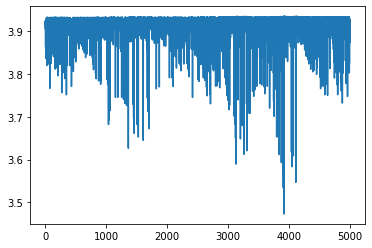

VAL--> Correct: 9 out of 450, acc=0.02
TEST--> Correct: 9 out of 450, acc=0.02


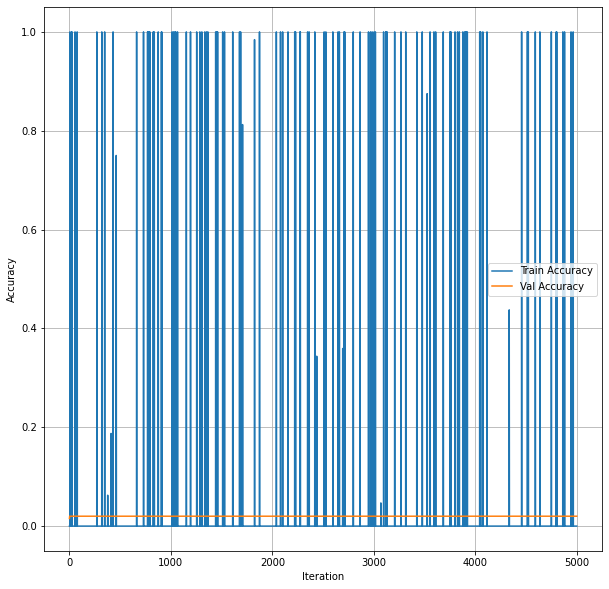

In [6]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = trainDFarray, trainDF["img_label"], valDFarray, valDF["img_label"], testDFarray, testDF["img_label"]
X_train, X_val, X_test = X_train/float(255), X_val/float(255), X_test/float(255)
X_train -= np.mean(X_train)
X_test -= np.mean(X_test)

X_val -= np.mean(X_val)

X_train, X_val, X_test = X_train.transpose((0,3,1,2)), X_val.transpose((0,3,1,2)), X_test.transpose((0,3,1,2))

batch_size = 64
D_out = 50

model = LeNet5()

losses = []
#optim = optimizer.SGD(model.get_params(), lr=0.0001, reg=0)
optim = SGDMomentum(model.get_params(), lr=0.0001, momentum=0.80, reg=0.00003)
# optim = Adam(model.get_params(), lr=0.001, beta1=0.9, beta2=0.999, epislon=1e-8)
criterion = CrossEntropyLoss()

train_acc = []
val_acc = []

# TRAIN
ITER = 5000
for i in range(ITER):
    # get batch, make onehot
    X_batch, Y_batch = get_batch(X_train, Y_train, batch_size)
    Y_batch_realnum = Y_batch.copy()
    Y_batch = MakeOneHot(Y_batch, D_out)

    # forward, loss, backward, step
    Y_pred = model.forward(X_batch)
    loss, dout = criterion.get(Y_pred, Y_batch)
    model.backward(dout)
    optim.step()


    print("iter: %s, loss: %s" % (i, loss))
    losses.append(loss)
    
    # TRAIN BATCH SET ACC
    Y_pred = model.forward(X_batch)
    result = np.argmax(Y_pred, axis=1) - Y_batch_realnum
    result = list(result)
    train_acc.append(result.count(0)/X_batch.shape[0])
    
    # VAL SET ACC
    Y_pred = model.forward(X_val)
    result = np.argmax(Y_pred, axis=1) - Y_val
    result = list(result)
    val_acc.append(result.count(0)/X_val.shape[0])


# save params
weights = model.get_params()
with open("weights.pkl","wb") as f:
    pickle.dump(weights, f)

### plot train loss
draw_losses(losses)

### plot acc plot
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(train_acc,label="Train Accuracy")
ax.plot(val_acc,label="Val Accuracy")
ax.legend()
ax.set_xlabel("Iteration")
ax.set_ylabel("Accuracy")
ax.grid()


# VAL SET ACC
Y_pred = model.forward(X_val)
result = np.argmax(Y_pred, axis=1) - Y_val
result = list(result)
print("VAL--> Correct: " + str(result.count(0)) + " out of " + str(X_val.shape[0]) + ", acc=" + str(result.count(0)/X_val.shape[0]))


# TEST SET ACC
Y_pred = model.forward(X_test)
result = np.argmax(Y_pred, axis=1) - Y_test
result = list(result)
print("TEST--> Correct: " + str(result.count(0)) + " out of " + str(X_test.shape[0]) + ", acc=" + str(result.count(0)/X_test.shape[0]))
